In [32]:
"""Script to solve scalar wave equation on Schwarzschild spacetime. Practice for the gravitational scattering case. The detailed \
physical setup is described by Barack & Burko (2000) (https://arxiv.org/abs/gr-qc/0007033)]. Essentially, we consider a scalar charge \
q plunging into a Schwarzschild Black Hole of mass M and calculate the first order self-force correction to the small object's motion \
as a perturbation to motion on the Schwarzschild background."""

"Script to solve scalar wave equation on Schwarzschild spacetime. Practice for the gravitational scattering case. The detailed physical setup is described by Barack & Burko (2000) (https://arxiv.org/abs/gr-qc/0007033)]. Essentially, we consider a scalar charge q plunging into a Schwarzschild Black Hole of mass M and calculate the first order self-force correction to the small object's motion as a perturbation to motion on the Schwarzschild background."

In [33]:
import time
from datetime import timedelta
import numpy as np
import scipy.special as scsp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [34]:
%matplotlib widget

In [35]:
# The main equation to evolve is eq. (4) from Barack & Burko. Note that the scalar field is evolved on a grid of null coordinates u and v, while
# the effective potential and source terms depend on the Schwarzschild radial coordinate r. Thus we need to be able to calculate r from given
# values of u and v.
# The null coordinates are defined in terms of the tortoise coordinate r_{*} = r + 2*M*log(r/(2*M) - 1) and the time coordinate t as
# v = t + r_{*}, u = t - r_{*}. A quick check with sympy shows that we can invert r_{*} (r) to find the radial coordinate as a function of the 
# tortoise coordinte as r = 2*M*( W( exp( -1 + r_{*}/(2*M) ) ) + 1 ) = 2*M*( W( exp( -1 + (v - u)/(4*M) ) ) + 1 ), where W is Lambert W function. 
# Thus we can define the effective potential in terms of the double null coordinates.

In [36]:
def rad_coord(v, u, M):
    """Compute the Schwarzschild radial coordinate r given the null coords u and v."""
    r = 2*M*(np.real(scsp.lambertw(np.exp(-1 + (v - u)/(4*M)))) + 1)
    return r

In [37]:
def eff_pot(v, u, l, M):
    """Calculate the effective potential given the null coords"""
    r = rad_coord(v, u, M)
    f = 1 - 2*M/r
    V = (f/4)*(l*(l + 1)/r**2 + 2*M/r**3)
    return V

In [38]:
def t_range(r_init, r_fin, M):
    """Construct the range of t values. Given a initial and final radial coordinate, first compute the corresponding tortoise coordinates rs. Then
    use t_{init} = 0 and t_{max} - t_{min} = rs_{max} - rs_{min}"""
    rs_init = r_init + 2*M*np.log(r_init/(2*M) - 1)
    rs_fin = r_fin + 2*M*np.log(r_fin/(2*M) - 1)
    t_fin = rs_fin - rs_init

    return rs_init, rs_fin, t_fin

In [39]:
def grid_setup(r_init, r_fin, size_step, M):
    """Set up double null grid (v, u). First, use the t_range function to determine the range of the tortoise coordinates as well as the final time.
    Next, initialise the v and u coordinates to rs_{init} and then construct a grid."""
    rs_in, rs_f, t_f = t_range(r_init, r_fin, M)

    v_init = rs_in
    u_init = - rs_in
    v_fin = t_f + rs_in
    u_fin = t_f - rs_in

    v_range = np.arange(v_init, v_fin, size_step)
    u_range = np.arange(u_init, u_fin, size_step)
    
    V, U = np.meshgrid(v_range, u_range)

    return V, U

In [40]:
def scalar_evo(v, u, l, size_step, M):
    """Evolve the scalar function psi on the double null grid (v, u). First initialise the scalar field array to 0, except for the initial point,
    which is initialised to 1. Then use the finite difference scheme described by Barack & Burko (2007)."""
    psi = np.zeros_like(v)
    psi[0, 0] = 1
    h_step = size_step

    for i in range(np.size(v, 0)-1):
        for j in range(np.size(v, 0)-1):
            v_mid = v[i, j] + h_step/2.0
            u_mid = u[i, j] + h_step/2.0
            
            psi[i+1, j+1] = -psi[i, j] + ( 1 - (h_step**2/2.0)*eff_pot(v_mid, u_mid, l, M) )*(psi[i, j+1] + psi[i+1, j])

    return psi

In [41]:
def field_decay(t_f, size_step, l):
    t_arr = np.arange(0, t_f, size_step)
    decay_exp = t_arr**(-2*l - 3)

    return decay_exp

In [42]:
def field_diag(psi, t_fin, size_step):
    """Return a 1D array containing the absolute values of the diagonal elements of the field psi( v, v ) for fixed tortoise coordinate 
    rs = rs_{init}. When the tortoise coordinate is fixed in this way, the variation in the null coordinates is the same as the variation in the 
    time coordinate t."""
    t_arr = np.arange(0, t_f, size_step)
    psi_diag = np.zeros_like(t_arr)

    for i in range(len(t_arr)):
        psi_diag[i] = np.abs(psi[i, i])

    return t_arr, psi_diag

0:01:48.565258


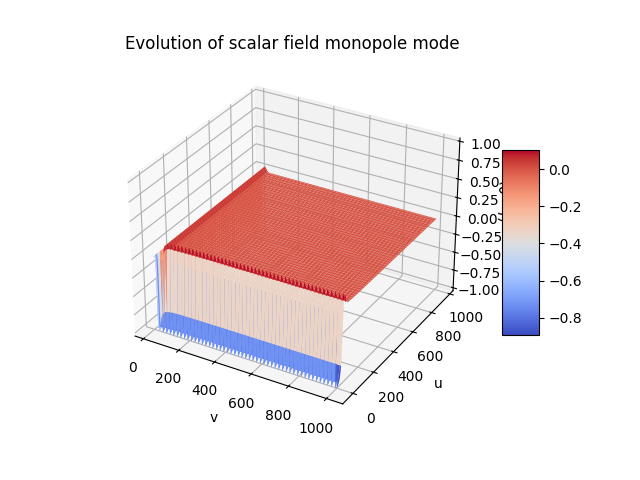

In [43]:
#if __name__ == "__main__":
start_time = time.monotonic()
r_init = 20
r_fin = 1000
size_step = 0.25
# num_step = 501
M = 1.0

v, u = grid_setup(r_init, r_fin, size_step, M)

l0 = 0
l1 = 1
scalar_field_l0 = scalar_evo(v, u, l0, size_step, M)

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(v, u, scalar_field_l0, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('v')
ax.set_ylabel('u')
ax.set_zlabel(r'$\psi^{(l=0)}$', fontsize=15)
ax.set_title('Evolution of scalar field monopole mode')
plt.show()

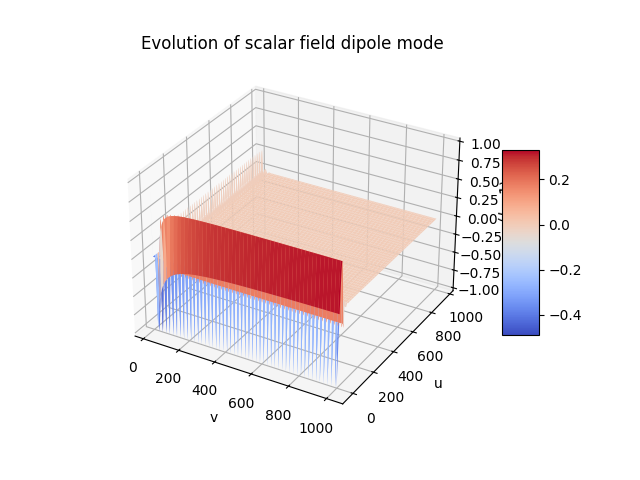

In [44]:
scalar_field_l1 = scalar_evo(v, u, l1, size_step, M)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(v, u, scalar_field_l1, cmap=cm.coolwarm, linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('v')
ax.set_ylabel('u')
ax.set_zlabel(r'$\psi^{(l=1)}$', fontsize=15)
ax.set_title('Evolution of scalar field dipole mode')
plt.show()

In [45]:
# Instead of a 3d plot like this, it makes more sense to look at the absolute value of the scalar field at a fixed radius, say r = r_{init}
# as time varies, on a log-log scale. Essentially, we need \log( \abs{ \psi^{( l = 0 )}(t, rs = rs_{init}) } ) vs log(t). This corresponds to 
# plotting the values of \log ( \abs{\psi (v, u)} ) on the "diagonal" starting at (v_0, u_0) and ending at (v_{fin}, u_{fin}). When r is fixed, 
# the range of v or u is the same as that of t. Plotting log(t) now corresponds to plotting log(v) or log(u).

# We expect the modes (on a logarithmic scale) to decay as -t^{-2l - 3}. This implies the monopole mode should decay as t^{-3} while the dipole mode
# should go as t^{-5}.

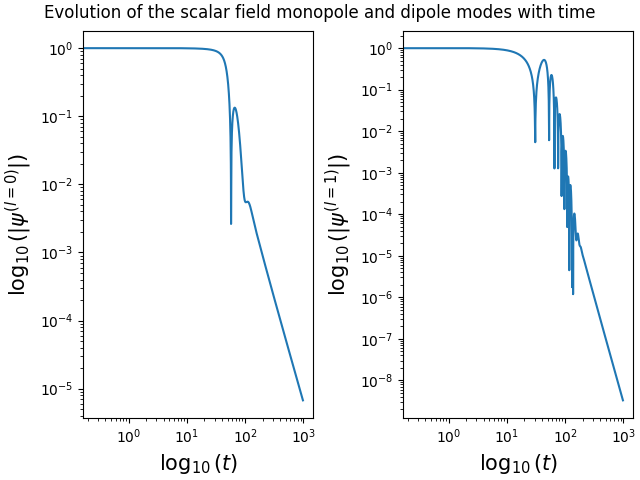

In [46]:
rs_in, rs_f, t_f = t_range(r_init, r_fin, M)

# exp_monopole_decay = field_decay(t_arr, l0)
# exp_dipole_decay = field_decay(t_arr, l1)

t_arr1, psi_diag_l0 = field_diag(scalar_field_l0, t_f, size_step)
t_arr2, psi_diag_l1 = field_diag(scalar_field_l1, t_f, size_step)
# psi_diag_l0 = np.zeros_like(t_arr)
# psi_diag_l1 = np.zeros_like(t_arr)

# for i in range(len(v)):
#     psi_diag_l0[i] = np.abs(scalar_field_l0[i, i])
#     psi_diag_l1[i] = np.abs(scalar_field_l1[i, i])

fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained')
ax1.loglog(t_arr1, psi_diag_l0)
# ax1.loglog(t_arr, exp_monopole_decay)
ax1.set_xlabel(r'$\log_{10}(t)$', fontsize=15)
ax1.set_ylabel(r'$\log_{10}( | \psi^{(l = 0)} | )$', fontsize=15)

ax2.loglog(t_arr2, psi_diag_l1)
# ax2.loglog(t_arr, exp_dipole_decay)
ax2.set_xlabel(r'$\log_{10}(t)$', fontsize=15)
ax2.set_ylabel(r'$\log_{10}( | \psi^{(l = 1)} | )$', fontsize=15)

fig.suptitle('Evolution of the scalar field monopole and dipole modes with time')
plt.show()

In [47]:
# Perform convergence tests on the results. Run the code for step sizes h = 1/16, 1/32, 1/64 

In [48]:
h1 = 1/8
h2 = 1/16
h3 = 1/32

v_l0_h1, u_l0_h1 = grid_setup(r_init, r_fin, h1, M)
v_l0_h2, u_l0_h2 = grid_setup(r_init, r_fin, h2, M)
v_l0_h3, u_l0_h3 = grid_setup(r_init, r_fin, h3, M)

In [49]:
start_time2 = time.monotonic()
psi_l0_h1 = scalar_evo(v_l0_h1, u_l0_h1, l0, h1, M)
end_time2 = time.monotonic()
print(timedelta(seconds=end_time2 - start_time2))

0:16:26.093171


In [50]:
start_time3 = time.monotonic()
psi_l0_h2 = scalar_evo(v_l0_h2, u_l0_h2, l0, h2, M)
end_time3 = time.monotonic()
print(timedelta(seconds=end_time3 - start_time3))

0:53:32.483773


In [51]:
# start_time4 = time.monotonic()
# psi_l0_h3 = scalar_evo(v_l0_h3, u_l0_h3, l0, h3, M)
# end_time4 = time.monotonic()
# print(timedelta(seconds=end_time4 - start_time4))

In [52]:
t_arr_l0_h1, psi_l0_h1_diag = field_diag(psi_l0_h1, t_f, h1)
t_arr_l0_h2, psi_l0_h2_diag = field_diag(psi_l0_h2, t_f, h2)
# t_arr_l0_h3, psi_l0_h3_diag = field_diag(psi_l0_h3, t_f, h3)

In [53]:
np.size(psi_l0_h1_diag), np.size(psi_l0_h2_diag) #, np.size(psi_l0_h3_diag)

(7905, 15809)

In [54]:
psi_l0_h2_diag_skip = psi_l0_h2_diag[0:-1:2]
# psi_l0_h3_diag_skip = psi_l0_h3_diag[0:-1:4]
len(psi_l0_h1_diag), len(psi_l0_h2_diag_skip) #, len(psi_l0_h3_diag_skip)

(7905, 7904)

In [55]:
psi_l0_h1_diag[:]

array([1.00000000e+00, 1.00000000e+00, 9.99998242e-01, ...,
       6.73816098e-06, 6.73558931e-06, 6.73301895e-06])

In [56]:
psi_l0_h2_diag_skip[:]

array([1.00000000e+00, 9.99999561e-01, 9.99997363e-01, ...,
       6.74012648e-06, 6.73755382e-06, 6.73498247e-06])

In [57]:
len(t_arr_l0_h1), len(t_arr_l0_h2) #, len(t_arr_l0_h3)

(7905, 15809)

In [58]:
# psi_l0_h3_diag_skip[:]

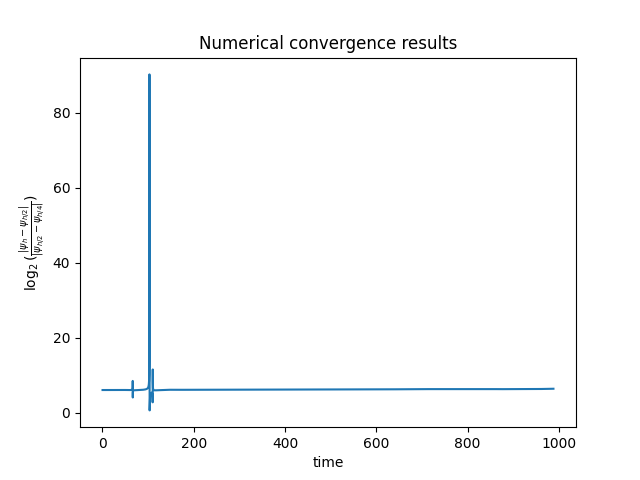

In [101]:
psi_ratio = np.abs((np.delete(psi_l0_h1_diag, [0, 1]) - np.delete(psi_l0_h2_diag_skip, 0))/(np.delete(psi_l0_h2_diag_skip, 0) \
                                                                                           - np.delete(psi_l0_h3_diag_skip, 0)))
t_arr_new = np.delete(t_arr_l0_h1, [0, 1])

plt.close('all')
fig, ax = plt.subplots()
ax.plot(t_arr_new, psi_ratio)
ax.set_xlabel('time')
ax.set_ylabel(r'$\log_{2} ( \frac{ | \psi_h - \psi_{h/2} | }{ | \psi_{h/2} - \psi_{h/4} | } )$')
ax.set_title('Numerical convergence results')
plt.show()